In [5]:
import numpy as np
np.random.seed(42)
from google.colab import drive
drive.mount('/content/drive')
from keras.models import Model

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
data=pd.read_json("/content/drive/My Drive/sarcasm/Sarcasm_Headlines_Dataset.json", lines=True)

In [0]:
text = data.headline.tolist()
label = np.array(data.is_sarcastic.tolist())

In [0]:
import keras

from keras.preprocessing.text import Tokenizer
# create the tokenizer
t = Tokenizer()
# fit the tokenizer on the documents
seq=t.fit_on_texts(text)

In [0]:
sequences = t.texts_to_sequences(text)

In [10]:
embeddings_index = {}
f = open('/content/drive/My Drive/sarcasm/glove.6B.200d.txt')
for line in f:
    values = line.split(' ')
    word = values[0] ## The first entry is the word
    coefs = np.asarray(values[1:], dtype='float32') ## These are the vecotrs representing the embedding for the word
    embeddings_index[word] = coefs
f.close()

print('GloVe data loaded')

GloVe data loaded


In [0]:
vocab_size=len(t.word_index)
word_index = t.word_index

In [0]:
EMBEDDING_DIM = embeddings_index.get('the').shape[0]
embedding_matrix = np.zeros((vocab_size+1, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > vocab_size:
        continue
    embedding_vector = embeddings_index.get(word) ## This references the loaded embeddings dictionary
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [14]:
embedding_matrix.shape

(29657, 200)

In [0]:
from keras.preprocessing.sequence import pad_sequences
train=pad_sequences(sequences, maxlen=100,padding='pre')

In [0]:
from sklearn.model_selection import train_test_split

X_train,X_testVal,y_train,y_testVal=train_test_split(train,label,test_size=0.3,stratify=label)
X_val,X_test,y_val,y_test=train_test_split(X_testVal,y_testVal,test_size=0.5,stratify=y_testVal)

In [17]:
from imblearn.over_sampling import RandomOverSampler
rus = RandomOverSampler(return_indices=True)
X_rus_train, y_rus_train, id_rus = rus.fit_sample(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [0]:
from keras.callbacks import History,EarlyStopping
hist = History()
early=EarlyStopping(monitor='val_loss', patience=3, mode='auto', restore_best_weights=False)

In [0]:
from keras.layers import Embedding, Conv2D, Dense, Dropout,MaxPool2D,Flatten,Input,Reshape,Concatenate
from keras.models import Model
from keras import optimizers
import keras.utils as ku
from keras import regularizers
filter_sizes = [3,4,5]
num_filters = 32
num_filters = 32
opt=optimizers.adam(lr=1.5e-5)
sequence_input = Input(shape=(100,), dtype='int32')
embedding_layer = Embedding(input_dim=29657, output_dim=200,input_length=100,name="embedding")(sequence_input)
reshape = Reshape((100,200,1))(embedding_layer)
conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], 200), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], 200), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], 200), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
    
maxpool_0 = MaxPool2D(pool_size=(100 - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(100 - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(100 - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)
    
concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)
dropout = Dropout(0.5)(flatten)
output = Dense(2, activation='softmax')(dropout)
    
model = Model(inputs=sequence_input, outputs=output)
    
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


In [21]:
model.fit(X_rus_train,ku.to_categorical(y_rus_train,num_classes=2),epochs=15,
    validation_data=(X_val,ku.to_categorical(y_val,num_classes=2)),callbacks=[hist,early],shuffle=True)

W0716 21:28:49.746807 139644627388288 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 20978 samples, validate on 4006 samples
Epoch 1/15
20978/20978 [==============================] - 13s 634us/step - loss: 0.6900 - acc: 0.5375 - val_loss: 0.6859 - val_acc: 0.6068
Epoch 2/15
20978/20978 [==============================] - 11s 512us/step - loss: 0.6770 - acc: 0.6099 - val_loss: 0.6738 - val_acc: 0.7057
Epoch 3/15
20978/20978 [==============================] - 11s 512us/step - loss: 0.6602 - acc: 0.6748 - val_loss: 0.6557 - val_acc: 0.7386
Epoch 4/15
20978/20978 [==============================] - 11s 510us/step - loss: 0.6369 - acc: 0.7292 - val_loss: 0.6303 - val_acc: 0.7554
Epoch 5/15
20978/20978 [==============================] - 11s 510us/step - loss: 0.6057 - acc: 0.7728 - val_loss: 0.6007 - val_acc: 0.7626
Epoch 6/15
20978/20978 [==============================] - 11s 508us/step - loss: 0.5724 - acc: 0.7956 - val_loss: 0.5705 - val_acc: 0.7678
Epoch 7/15
20978/20978 [==============================] - 11s 508us/step - loss: 0.5376 - acc: 0.8060 - val_loss: 0.5

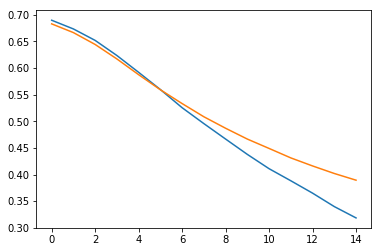

In [0]:
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.show()

In [0]:
y_te_pred=np.argmax(model.predict(X_test),axis=1)
y_tr_pred=np.argmax(model.predict(X_train),axis=1)

In [0]:
from sklearn.metrics import accuracy_score,f1_score,precision_recall_fscore_support,classification_report
precision, recall, fscore, support = precision_recall_fscore_support(y_te_pred, y_test)
print(classification_report(y_te_pred, y_test))

              precision    recall  f1-score   support

           0       0.81      0.87      0.84      2097
           1       0.85      0.78      0.81      1910

    accuracy                           0.83      4007
   macro avg       0.83      0.83      0.83      4007
weighted avg       0.83      0.83      0.83      4007



In [0]:
precision, recall, fscore, support = precision_recall_fscore_support(y_tr_pred, y_train)
print(classification_report(y_tr_pred, y_train))

              precision    recall  f1-score   support

           0       0.90      0.93      0.91     10117
           1       0.91      0.87      0.89      8579

    accuracy                           0.90     18696
   macro avg       0.90      0.90      0.90     18696
weighted avg       0.90      0.90      0.90     18696

